# MNIST Classifier

In this notebook you will create both, an mnist tabular dataset and a classifier.

## 1.- import the Operating System (os) module in python and any other library you need

In [1]:
import os
import zipfile
from PIL import Image
import numpy as np
import pandas as pd
from IPython.display import display

import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import TruncatedSVD

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline

#Tree Models
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier

#NonTree Models
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__) # Try to use 0.24

Pandas   1.3.2
Sklearn  1.0.1


## Get the dataset

In [ ]:
os.environ['KAGGLE_USERNAME'] = "anthonyemeka12"
os.environ['KAGGLE_KEY']      = "52a32a7dda673d7b0705657b185547c5"
!pip install --upgrade kaggle
!kaggle datasets download -d scolianni/mnistasjpg
DATA_PATH = "./mnistasjpg/"

#unzip
with zipfile.ZipFile('mnistasjpg.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_PATH)
os.remove('mnistasjpg.zip')

## 2.- As you can see each class has its own folder (Do it only for train). 

    - Iterate folder by folder ( os.listdir() )
    - Inside each folder: 
        1.- Read the image
        2.- Reshape it into a flat array (784,)
        3.- Save the data into a pandas dataframe apending the column name as the class
    - Save the data into a CSV

    Note: if it takes to long try doing only 100 images per folder for the CSV.

In [213]:
def showImage(img,type='img'):
    if type == 'img':
        img = Image.open(img)
        img = img.convert('L')
    elif type == 'np':
        dim = int(np.sqrt(img.reshape(-1,1).shape[0]))
        img = img.reshape(dim,dim)
        img = Image.fromarray(img.astype(int))
    else:
        raise Exception("type must be img or np")
    
    # display(img)
    return img

def image2Numpy(img):
    dim = int(np.sqrt(784))
    img = Image.open(img)
    img = img.convert('L')
    img = img.resize((dim,dim))
    arr = np.array(img, dtype=float).flatten()
    return arr

def getListFromImages(path):
    x = []
    p_img = os.listdir(path)
    for im in p_img:
        pth = path+'/'+im
        x.append(list(image2Numpy(pth)))
    return np.array(x) if len(x) > 1 else np.array([x])

def predSingle(model,path):
    sample = image2Numpy(path)
    sample = pd.DataFrame(sample.reshape(1,-1),columns=columns_train[1:])
    pred = int(best_model.predict(sample)[0])
    print("Real Image:")
    display(showImage(path))
    print("Predicted Image:")
    print(pred)
    return pred

In [6]:
#Paths to train and test images
train_path = 'mnistasjpg/trainingSet/trainingSet/'
test_path = 'mnistasjpg/testSet/testSet/'


In [9]:

#Train folders
train_folders = os.listdir(train_path)

#Convert images to numbers and store in x_arr with their corresponding targets in y_arr
x_arr = []
y_arr = []
print("Started ....")
for p in train_folders:
    p_img = os.listdir(train_path+p)
    x_arr.extend( list( getListFromImages(train_path+p) ) )
    y_arr.extend([int(p) for i in range(len(p_img))])
    print("Done with Target ("+p+")")
        
x_arr = np.array(x_arr)
y_arr = np.array(y_arr)

#Get shapes of returned arrays
print("x_shape={},y_shape={}" .format(x_arr.shape,y_arr.shape))


Started ....
Done with Target (0)
Done with Target (1)
Done with Target (2)
Done with Target (3)
Done with Target (4)
Done with Target (5)
Done with Target (6)
Done with Target (7)
Done with Target (8)
Done with Target (9)
x_shape=(42000, 784),y_shape=(42000,)


In [ ]:
pth = train_path+p+'/'+p_img[0]
pth = 'mnistasjpg/trainingSet/trainingSet/0/img_10010.jpg'

img = image2Numpy(pth)
showImage(x_arr[0],type='np')
# showImage(pth,type='img')

In [7]:
#Get test data into dataframe and save as csv
test_array = getListFromImages(test_path)
columns_test = ['p_'+str(i) for i in range(1,test_array.shape[1]+1)]
test_df = pd.DataFrame(test_array,columns=columns_test)
test_df.to_csv('data/test.csv',index=False)

In [10]:
#Get train data into dataframe and save as csv
columns_train = ['target']+['p_'+str(i) for i in range(1,x_arr.shape[1]+1)]
train_df = pd.DataFrame(np.concatenate((y_arr.reshape(-1,1),x_arr), axis=1),columns=columns_train)
train_df.to_csv('data/train.csv',index=False)

## 3.- Load the CSV

In [42]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

x = train_df.drop(columns=['target'])
y = train_df["target"]

## 4.- Create a dictionary of models (No preprocessing needed, it has already been done).
    
    Include both, tree models and mult models.

In [43]:
# Drop other vars not specified in columns_train

scalling = pipeline.Pipeline(steps=[
    ('scaler', preprocessing.QuantileTransformer(n_quantiles=100))
])

scalling_prepro = compose.ColumnTransformer(transformers=[
    ('num', scalling, columns_test)
], remainder='drop')

scalling_prepro


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler',
                                                  QuantileTransformer(n_quantiles=100))]),
                                 ['p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6',
                                  'p_7', 'p_8', 'p_9', 'p_10', 'p_11', 'p_12',
                                  'p_13', 'p_14', 'p_15', 'p_16', 'p_17',
                                  'p_18', 'p_19', 'p_20', 'p_21', 'p_22',
                                  'p_23', 'p_24', 'p_25', 'p_26', 'p_27',
                                  'p_28', 'p_29', 'p_30', ...])])

In [44]:
# tree_classifiers = {
#   "Decision Tree": DecisionTreeClassifier(),
#   "Extra Trees": ExtraTreesClassifier(),
#   "Random Forest": RandomForestClassifier(),
#   "AdaBoost": AdaBoostClassifier(),
#   "Skl GBM": GradientBoostingClassifier(),
#   "Skl HistGBM": HistGradientBoostingClassifier(),
#   "XGBoost": XGBClassifier(use_label_encoder=False,eval_metric='error'),
#   "LightGBM": LGBMClassifier(),
#   "CatBoost": CatBoostClassifier()
# }
# nonTree_classifiers = {
#   "Linear Regression": LinearRegression(),
#   "KNeighbors Classifier": KNeighborsClassifier(n_neighbors=10),
#   "Gaussian NB": GaussianNB(),
#   "Logistic Regression": LogisticRegression(),
#   "Svc": SVC()
# }
tree_classifiers = {
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees": ExtraTreesClassifier(),
  "AdaBoost": AdaBoostClassifier(),
  "Random Forest": RandomForestClassifier()
}
nonTree_classifiers = {
  "Linear Regression": LinearRegression(),
  "KNeighbors Classifier": KNeighborsClassifier(n_neighbors=10),
  "Gaussian NB": GaussianNB(),
  "Logistic Regression": LogisticRegression(),
  "Svc": SVC()
}

nonTree_classifiers = {name: pipeline.make_pipeline(model) for name, model in nonTree_classifiers.items()}
nonTree_classifiers_noScaling = {name+'_no': pipeline.make_pipeline(scalling_prepro, model) for name, model in nonTree_classifiers.items()}
tree_classifiers = {name: pipeline.make_pipeline(scalling_prepro,model) for name, model in tree_classifiers.items()}
tree_classifiers_noScaling = {name+'_no': pipeline.make_pipeline(model) for name, model in tree_classifiers.items()}

classifyDic = nonTree_classifiers
classifyDic.update(nonTree_classifiers_noScaling)
classifyDic.update(tree_classifiers)
classifyDic.update(tree_classifiers_noScaling)

classifyDic["Random Forest"]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   QuantileTransformer(n_quantiles=100))]),
                                                  ['p_1', 'p_2', 'p_3', 'p_4',
                                                   'p_5', 'p_6', 'p_7', 'p_8',
                                                   'p_9', 'p_10', 'p_11',
                                                   'p_12', 'p_13', 'p_14',
                                                   'p_15', 'p_16', 'p_17',
                                                   'p_18', 'p_19', 'p_20',
                                                   'p_21', 'p_22', 'p_23',
                                                   'p_24', 'p_25', 'p_26',
                                                   'p_27', 'p_28', 'p_29',
                                                   'p_30', ...])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [45]:
# Train Test Split
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x,y,
    test_size=.2,
    stratify=y,
    random_state=0
)

#Train model
results_test_split = []

for model_name, model in classifyDic.items():
    start_time = time.time()
    
    # FOR EVERY PIPELINE (PREPRO + MODEL) -> TRAIN WITH TRAIN DATA (x_train)
    model.fit(x_train, y_train)
    
    # GET PREDICTIONS USING x_val
    pred = model.predict(x_val)

    total_time = time.time() - start_time

    results_test_split.append(
        {
            "Model": model_name,
            "Accuracy": metrics.accuracy_score(y_val, np.round(abs(pred)). astype(int))*100,
            "Bal Acc.": metrics.balanced_accuracy_score(y_val, np.round(abs(pred)). astype(int))*100,
            "Time": total_time
        }
        )

C:\Users\Asus\.conda\envs\strive\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\Asus\.conda\envs\strive\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\.conda\envs\strive\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\Asus\.conda\envs\strive\lib\site-packages\sklearn\linear_model\_logis

In [46]:
results_ord_train_test_split = pd.DataFrame.from_dict(results_test_split).sort_values('Accuracy',ascending=False)
results_ord_train_test_split

,Model,Accuracy,Bal Acc.,Time
4,Svc,97.547619,97.524004,128.787541
1,KNeighbors Classifier,95.821429,95.747346,6.743589
13,Random Forest,95.761905,95.730722,34.034297
17,Random Forest_no,95.642857,95.613487,33.458607
9,Svc_no,95.535714,95.504121,235.325545
15,Extra Trees_no,94.654762,94.600616,30.850219
11,Extra Trees,94.380952,94.309899,30.151706
3,Logistic Regression,91.726190,91.634824,7.716058
6,KNeighbors Classifier_no,91.583333,91.418447,9.967616
8,Logistic Regression_no,89.416667,89.293348,9.133309


In [48]:
skf = model_selection.StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=0
)

#Train model
results_cv = []

for model_name, model in classifyDic.items():
    start_time = time.time()
    
    # TRAIN AND GET PREDICTIONS USING cross_val_predict() and x,y
    pred = cross_val_predict(model, x, y, cv=skf)

    total_time = time.time() - start_time

    results_cv.append(
        {
            "Model": model_name,
            "Accuracy": metrics.accuracy_score(y, np.round(abs(pred)). astype(int))*100,
            "Bal Acc.": metrics.balanced_accuracy_score(y, np.round(abs(pred)). astype(int))*100,
            "Time": total_time
        }
        )

C:\Users\Asus\.conda\envs\strive\lib\site-packages\sklearn\metrics\_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\Asus\.conda\envs\strive\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\.conda\envs\strive\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https

KeyboardInterrupt: 

In [50]:
results_ord_cv = pd.DataFrame.from_dict(results_cv).sort_values('Accuracy',ascending=False)
results_ord_cv

,Model,Accuracy,Bal Acc.,Time
4,Svc,97.626190,97.613088,1029.146896
1,KNeighbors Classifier,96.369048,96.314354,40.968117
6,KNeighbors Classifier_no,92.176190,92.014202,71.043820
3,Logistic Regression,91.761905,91.646739,75.048158
8,Logistic Regression_no,90.121429,90.007183,101.965947
2,Gaussian NB,62.761905,62.049871,7.450048
7,Gaussian NB_no,36.014286,35.543910,37.545689
0,Linear Regression,22.673810,22.636979,17.368935
5,Linear Regression_no,21.602381,21.519563,46.126986


## 5.- Using either cross validation or stratification find out which is the best model
    - Base your code on the previous two days examples

In [51]:
best_Accuracy = -np.inf
best_model_name = None
for d in [results_ord_cv, results_ord_train_test_split]:
    print(d.Accuracy.max())
    if d.Accuracy.max() > best_Accuracy:
        best_model_name = d[d.Accuracy == d.Accuracy.max()].Model.values[0]


best_model = classifyDic[best_model_name]
best_model.fit(x,y)

97.62619047619047
97.54761904761905


Pipeline(steps=[('svc', SVC())])

## Predict All Test Set

In [177]:
test_pred = best_model.predict(test_df)

## Single Value Prediction

Real Image:


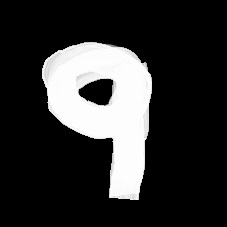

Predicted Image:
9


9

In [214]:
newpath = 'data/sample/sample.jpg'
predSingle(best_model,newpath)

## Optional: Can you rotate an image?